In [1]:
import sys
import torch
import geoopt

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import trange
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from geoopt import linalg, ManifoldParameter, Stiefel
from geoopt.optim import RiemannianSGD, RiemannianAdam
from copy import deepcopy

sys.path.append("./lib/data")
from get_data import get_data, get_cov

sys.path.append("./lib/spdnet")
import nn as nn_spd
from optimizers import MixOptimizer

sys.path.append("./lib")
from swspd import sliced_wasserstein_spd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [3]:
seed = 2023

# random.seed(args.seed)
# np.random.seed(args.seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.benchmark=True

### Data

In [4]:
subject = 1
Xs, ys = get_data(subject, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(subject, False, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1

In [5]:
print(Xs.shape, cov_Xs.shape, Xt.shape, cov_Xt.shape)

(273, 22, 1750) torch.Size([273, 1, 1, 22, 22]) (281, 22, 1750) torch.Size([281, 1, 1, 22, 22])


In [6]:
d = 22
n_classes = 4

freq = 0

In [7]:
def plot_tsne(Xs, Xt, suptitle=None):
    log_Xs = linalg.sym_logm(Xs.detach().cpu()).reshape(-1, d*d)
    log_Xt = linalg.sym_logm(Xt.detach().cpu()).reshape(-1, d*d)

    log_data = torch.cat([log_Xs, log_Xt], dim=0)

    X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(log_data.numpy())


    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
    ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

    ax[0].legend()
    ax[1].legend()
    
    if suptitle is not None:
        plt.suptitle(suptitle)
        
    plt.show()

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


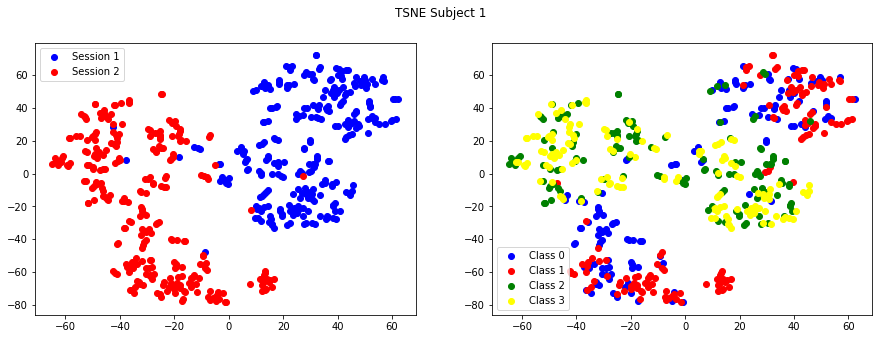

In [8]:
plot_tsne(cov_Xs[:,:,freq], cov_Xt[:,:,freq], suptitle="TSNE Subject 1")

### Neural Net

In [9]:
class mlp_spd(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()

        self.dense1 = nn.Linear(d_in, 10)
        self.dense2 = nn.Linear(10, d_out)
        self.logeig = nn_spd.LogEig() ## projection on Symmetric matrices


    def forward(self, x_spd):
        x = self.logeig(x_spd).view(x_spd.shape[0], -1)
        
        ## Amélioration possible: Upper vect of log instead of just log

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
            
        return F.softmax(x, dim=-1)
    
    
# class mlp_spd(nn.Module):
#     def __init__(self, d_in, d_out):
#         super().__init__()

#         self.dense1 = nn.Linear(d_in, 100)
#         self.dense = nn.Linear(100, 10)
#         self.dense2 = nn.Linear(10, d_out)
#         self.logeig = nn_spd.LogEig() ## projection on Symmetric matrices


#     def forward(self, x_spd):
#         x = self.logeig(x_spd).view(x_spd.shape[0], -1)
        
#         ## Amélioration possible: Upper vect of log instead of just log

#         x = F.relu(self.dense1(x))
#         x = F.relu(self.dense(x))
#         x = F.relu(self.dense2(x))
            
#         return F.softmax(x, dim=-1)
    
    
# class mlp_spd(nn.Module):
#     def __init__(self, d_in, d_out):
#         super().__init__()

#         self.dense1 = nn.Linear(d_in, 10)
#         self.dense2 = nn.Linear(10, d_out)
#         self.dense = nn.Linear(d_in, d_out)
#         self.logeig = nn_spd.LogEig() ## projection on Symmetric matrices


#     def forward(self, x_spd):
#         x = self.logeig(x_spd).view(x_spd.shape[0], -1)
        
#         ## Amélioration possible: Upper vect of log instead of just log

# #         x = F.relu(self.dense1(x))
# #         x = F.relu(self.dense2(x))
#         x = F.relu(self.dense(x))
            
#         return F.softmax(x, dim=-1)
    

In [10]:
def init_all(model, init_func, *params, **kwargs):
    for p in model.parameters():
        init_func(p, *params, **kwargs)
        
        
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
#         torch.nn.init.xavier_uniform_(m.weight)
#         m.bias.data.fill_(0.01)
        
        
def weights_init_uniform(m):
        classname = m.__class__.__name__
        # for every Linear layer in a model..
        if classname.find('Linear') != -1:
            # apply a uniform distribution to the weights and a bias=0
            m.weight.data.uniform_(0.0, 1.0)
            m.bias.data.fill_(0)

### Training

#### Training on Target

In [15]:
seed = 2023
# seed = 42

epochs = 1000


for seed in [2023]: #np.random.choice(10000, size=10, replace=False):

    # random.seed(args.seed)
    # np.random.seed(args.seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.benchmark=True


    # num_projs = 500

    criterion = nn.CrossEntropyLoss()

    classifier = mlp_spd(d*d, n_classes).to(device)
    # init_all(classifier, torch.nn.init.normal_, mean=0., std=1) 
    # classifier.apply(weights_init_uniform)
    # classifier.apply(init_weights)
    # init_all(classifier, torch.nn.init.constant_, 0.) 

    print("Number of parameters:", str(sum(p.numel() for p in classifier.parameters())))

    # optimizer = MixOptimizer(list(classifier.parameters()), lr=lr)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
#     optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-3) #, momentum=0.9, weight_decay=5e-4)

#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    L_loss = []
    L_acc = []

    pbar = trange(epochs)

    for e in pbar:    
        y_hat = classifier(cov_Xt[:,:,freq].type(torch.float32))
        classif_loss = criterion(y_hat, yt)

        loss = classif_loss
        loss.backward()

    #     for p in classifier.parameters():
    # #         print(p)
    #         if p.grad is not None:
    #             print(torch.sum(p.grad**2))

    #     print(sum(p.grad**2) for p in classifier.parameters() if p.grad is not None)



        L_loss.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()

#         scheduler.step()

        with torch.no_grad():
            y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
            acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)

            L_acc.append(acc.item())

        pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"acc = {acc.item():.3f}")




Number of parameters: 4894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:17<00:00, 12.95it/s, loss = 0.756 acc = 99.644]


In [16]:
y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 99.64412689208984%


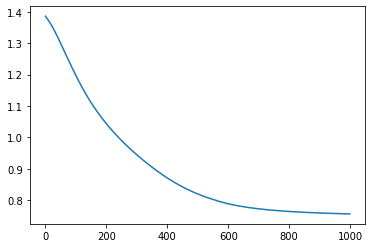

In [17]:
plt.plot(L_loss)
plt.show()

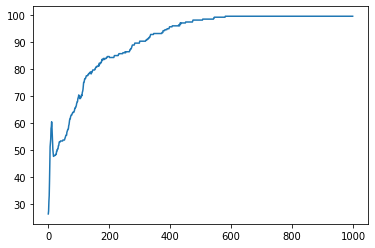

In [18]:
plt.plot(L_acc)
plt.show()

#### Training on Source

In [15]:
seed = 2023

# random.seed(args.seed)
# np.random.seed(args.seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.benchmark=True


epochs = 1000
# num_projs = 500
d = 22
n_classes = 4

freq = 0

criterion = nn.CrossEntropyLoss()

classifier = mlp_spd(d*d, n_classes).to(device)
# init_all(classifier, torch.nn.init.normal_, mean=0., std=1) 
# classifier.apply(weights_init_uniform)
# classifier.apply(init_weights)
# init_all(classifier, torch.nn.init.constant_, 0.) 

print("Number of parameters:", str(sum(p.numel() for p in classifier.parameters())))

# optimizer = MixOptimizer(list(classifier.parameters()), lr=lr)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-2) #, momentum=0.9, weight_decay=5e-4)

L_loss = []
L_acc = []
L_acc_test = []

pbar = trange(epochs)

for e in pbar:    
    y_hat = classifier(cov_Xs[:,:,freq].type(torch.float32))
    classif_loss = criterion(y_hat, ys)
    
    loss = classif_loss
    loss.backward()
    
    L_loss.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        y_test = classifier(cov_Xs[:,:,freq].type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == ys) * 100/len(ys)
        L_acc.append(acc.item())
        
        
        y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
        acc_test = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        L_acc_test.append(acc_test.item())
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"acc = {acc.item():.3f} " + f"acc_test = {acc_test.item():.3f}")



Number of parameters: 4894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.44it/s, loss = 0.756 acc = 99.634 acc_test = 71.530]


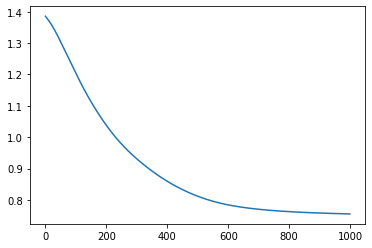

In [16]:
plt.plot(L_loss)
plt.show()

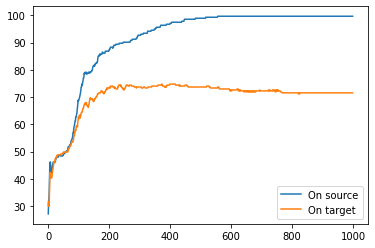

In [17]:
plt.plot(L_acc, label="On source")
plt.plot(L_acc_test, label="On target")
plt.legend()
plt.show()

### SPDNet

In [20]:
def bimap(X,W):
    '''
    Bilinear mapping function
    :param X: Input matrix of shape (batch_size,n_in,n_in)
    :param W: Stiefel parameter of shape (n_in,n_out)
    :return: Bilinearly mapped matrix of shape (batch_size,n_out,n_out)
    '''
    return W.t().matmul(X).matmul(W)


def init_bimap_parameter(W):
    """ initializes a (ho,hi,ni,no) 4D-StiefelParameter"""
    ho, hi, ni, no = W.shape
    for i in range(ho):
        for j in range(hi):
            v = torch.empty(ni, ni, dtype=W.dtype, device=W.device).uniform_(0.,1.)
            vv = torch.svd(v.matmul(v.t()))[0][:,:no]
            W.data[i,j]=vv

            
def bimap_channels(X,W):
    '''
    Bilinear mapping function over multiple input and output channels
    :param X: Input matrix of shape (batch_size,channels_in,n_in,n_in)
    :param W: Stiefel parameter of shape (channels_out,channels_in,n_in,n_out)
    :return: Bilinearly mapped matrix of shape (batch_size,channels_out,n_out,n_out)
    '''
    # Pi=th.zeros(X.shape[0],1,W.shape[-1],W.shape[-1],dtype=X.dtype,device=X.device)
    # for j in range(X.shape[1]):
    #     Pi=Pi+bimap(X,W[j])
    batch_size,channels_in, n_in, _ = X.shape
    channels_out, _, _, n_out = W.shape
    P = torch.zeros(batch_size,channels_out,n_out,n_out,dtype=X.dtype,device=X.device)
    for co in range(channels_out):
        P[:,co,:,:] = sum([bimap(X[:,ci,:,:],W[co,ci,:,:]) for ci in range(channels_in)])
    return P


class BiMap(nn.Module):
    """
    Input X: (batch_size,hi) SPD matrices of size (ni,ni)
    Output P: (batch_size,ho) of bilinearly mapped matrices of size (no,no)
    Stiefel parameter of size (ho,hi,ni,no)
    """
    def __init__(self, ho, hi, ni, no):
        super(BiMap, self).__init__()
        
        self._W = ManifoldParameter(torch.empty(ho, hi, ni, no, dtype=torch.double, device=device), manifold=Stiefel())

#         self._W=functional.StiefelParameter(th.empty(ho,hi,ni,no,dtype=dtype,device=device))
        self._ho = ho
        self._hi = hi
        self._ni = ni
        self._no = no
        init_bimap_parameter(self._W)
        
    def forward(self,X):
        return bimap_channels(X, self._W)

In [21]:
def BatchDiag(P):
    """
    Input P: (batch_size,channels) vectors of size (n)
    Output Q: (batch_size,channels) diagonal matrices of size (n,n)
    """
    batch_size, channels, n = P.shape #batch size,channel depth,dimension
    Q = torch.zeros(batch_size, channels, n, n, dtype=P.dtype, device=P.device)
    for i in range(batch_size):
        for j in range(channels):
            Q[i,j] = P[i,j].diag()
    return Q


def modeig_forward(P, op, eig_mode='svd', param=None):
    '''
        Generic forward function of non-linear eigenvalue modification
        LogEig, ReEig, etc inherit from this class
        Input P: (batch_size,channels) SPD matrices of size (n,n)
        Output X: (batch_size,channels) modified symmetric matrices of size (n,n)
    '''
    batch_size, channels, n, n = P.shape #batch size,channel depth,dimension
    U = torch.zeros_like(P, device=P.device)
    S = torch.zeros(batch_size,channels, n, dtype= P.dtype,device= P.device)
    
    for i in range(batch_size):
        for j in range(channels):
            if(eig_mode == 'eig'):
                s, U[i,j] = torch.eig(P[i,j],True)
                S[i,j] = s[:,0]
            elif(eig_mode=='svd'):
                U[i,j],S[i,j],_ = torch.svd(P[i,j])
                
    S_fn = op.fn(S, param)
    X = U.matmul(BatchDiag(S_fn)).matmul(U.transpose(2,3))
    return X, U, S, S_fn


def modeig_backward(dx, U, S, S_fn, op, param=None):
    '''
    Generic backward function of non-linear eigenvalue modification
    LogEig, ReEig, etc inherit from this class
    Input P: (batch_size,channels) SPD matrices of size (n,n)
    Output X: (batch_size,channels) modified symmetric matrices of size (n,n)
    '''
    # if __debug__:
    #     import pydevd
    #     pydevd.settrace(suspend=False, trace_only_current_thread=True)
    S_fn_deriv = BatchDiag(op.fn_deriv(S, param))
    SS = S[...,None].repeat(1,1,1,S.shape[-1])
    SS_fn = S_fn[...,None].repeat(1,1,1,S_fn.shape[-1])
    L = (SS_fn-SS_fn.transpose(2,3))/(SS-SS.transpose(2,3))
    
    L[L==-np.inf] = 0 
    L[L==np.inf] = 0
    L[torch.isnan(L)] = 0
    L = L+S_fn_deriv
    
    dp = L*(U.transpose(2,3).matmul(dx).matmul(U))
    dp = U.matmul(dp).matmul(U.transpose(2,3))
    
    return dp



class Re_op():
    """ Log function and its derivative """
    _threshold=1e-4
    @classmethod
    def fn(cls,S,param=None):
        return nn.Threshold(cls._threshold,cls._threshold)(S)
    @classmethod
    def fn_deriv(cls,S,param=None):
        return (S>cls._threshold).double()
    

class ReEig_(torch.autograd.Function):
    """
    Input P: (batch_size,h) SPD matrices of size (n,n)
    Output X: (batch_size,h) of rectified eigenvalues matrices of size (n,n)
    """
    @staticmethod
    def forward(ctx,P):
        X, U, S, S_fn = modeig_forward(P, Re_op)
        ctx.save_for_backward(U, S, S_fn)
        return X
    @staticmethod
    def backward(ctx,dx):
        # if __debug__:
        #     import pydevd
        #     pydevd.settrace(suspend=False, trace_only_current_thread=True)
        U, S, S_fn = ctx.saved_variables
        return modeig_backward(dx, U, S, S_fn, Re_op)


class ReEig(nn.Module):
    """
    Input P: (batch_size,h) SPD matrices of size (n,n)
    Output X: (batch_size,h) of rectified eigenvalues matrices of size (n,n)
    """
    def forward(self,P):
        return ReEig_.apply(P)

In [22]:
class SPDNet(nn.Module):
    def __init__(self, d):
        super().__init__()
                
        self.re = ReEig()
        self.bimap1 = BiMap(1, 1, d, d)
        self.bimap2 = BiMap(1, 1, d, d)
        self.bimap3 = BiMap(1, 1, d, d)
        
    def forward(self,x):
        x_spd = self.re(self.bimap1(x))
        x_spd = self.re(self.bimap2(x_spd))
        x_spd = self.bimap3(x_spd)
        
        return x_spd

#### Classifier + SPDNet (NO ALIGNMENT)

In [39]:
seed = 2023

# random.seed(args.seed)
# np.random.seed(args.seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.benchmark=True

classifier = mlp_spd(d*d, n_classes).to(device)
model = SPDNet(22).to(device)

# optimizer_sw = RiemannianSGD(model.parameters(), lr=100)
optimizer_sw = RiemannianAdam(model.parameters(), lr=1e-2)

optimizer_classif = torch.optim.Adam(classifier.parameters(), lr=1e-3)

L_sw = []
L_classif = []
L = []

L_acc = []
L_acc_test = []

n_epochs = 500
num_projs = 1000
pbar = trange(n_epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,freq])
#     zt = model(cov_Xt[:,:,freq])
    
    y_hat = classifier(zs.type(torch.float32))
        
#     align_loss = sliced_wasserstein_spd(zs[:,0], zt[:,0], num_projs, device, p=2)
    classif_loss = criterion(y_hat, ys)    
    
    loss = classif_loss # + align_loss
    loss.backward()
    
    optimizer_sw.step()
    optimizer_classif.step()
    
    optimizer_sw.zero_grad()
    optimizer_classif.zero_grad()
    
#     L_sw.append(align_loss.item())
    L_classif.append(classif_loss.item())
    L.append(loss.item())
    
    with torch.no_grad():
        y_test = classifier(zs.type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == ys) * 100/len(ys)
        L_acc.append(acc.item())
        
        
        y_test = classifier(zt.type(torch.float32))
        acc_test = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        L_acc_test.append(acc_test.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}, " + f"Acc_source = {acc.item():.3f}, " +
                        f"Acc_target = {acc_test.item():.3f}")
    

  0%|                                                                                                                                                                                      | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_591190/2398972987.py:91: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  U, S, S_fn = ctx.saved_variables
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:46<00:00,  4.71it/s, loss = 0.778, Acc_source = 100.000, Acc_target = 25.623]


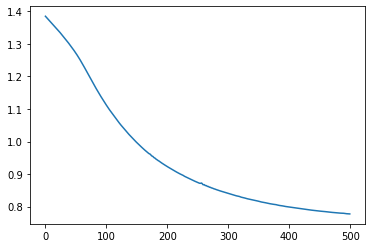

In [40]:
plt.plot(L_classif)
plt.show()

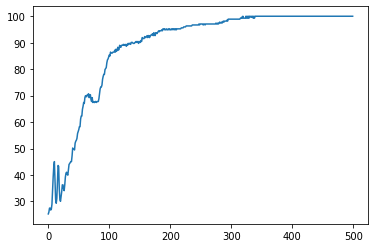

In [41]:
plt.plot(L_acc)
plt.show()

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


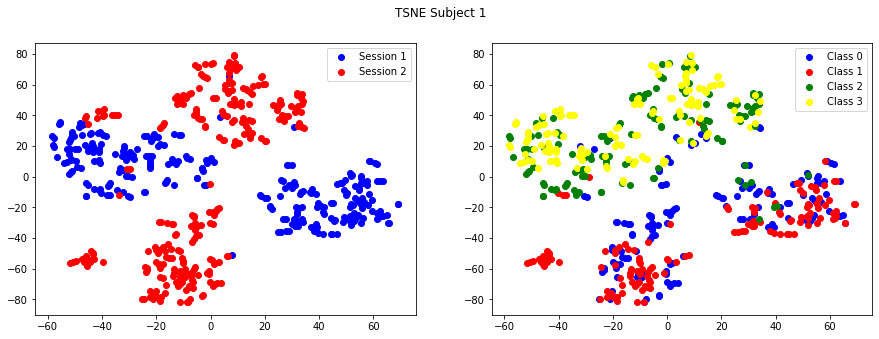

In [42]:
plot_tsne(model(cov_Xs[:,:,freq]).type(torch.float32), model(cov_Xt[:,:,freq]).type(torch.float32), 
          suptitle="TSNE Subject 1")

In [38]:
for seed in np.random.choice(10000, size=10, replace=False):

    # random.seed(args.seed)
    # np.random.seed(args.seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.benchmark=True

    classifier = mlp_spd(d*d, n_classes).to(device)
    model = SPDNet(22).to(device)

    # optimizer_sw = RiemannianSGD(model.parameters(), lr=100)
    optimizer_sw = RiemannianAdam(model.parameters(), lr=1e-2)

    optimizer_classif = torch.optim.Adam(classifier.parameters(), lr=1e-3)

    L_sw = []
    L_classif = []
    L = []

    L_acc = []
    L_acc_test = []

    n_epochs = 500
    num_projs = 1000
    pbar = trange(n_epochs)

    for e in pbar:
        zs = model(cov_Xs[:,:,freq])
    #     zt = model(cov_Xt[:,:,freq])

        y_hat = classifier(zs.type(torch.float32))

    #     align_loss = sliced_wasserstein_spd(zs[:,0], zt[:,0], num_projs, device, p=2)
        classif_loss = criterion(y_hat, ys)    

        loss = classif_loss # + align_loss
        loss.backward()

        optimizer_sw.step()
        optimizer_classif.step()

        optimizer_sw.zero_grad()
        optimizer_classif.zero_grad()

    #     L_sw.append(align_loss.item())
        L_classif.append(classif_loss.item())
        L.append(loss.item())

        with torch.no_grad():
            y_test = classifier(zs.type(torch.float32))
            acc = torch.sum(torch.argmax(y_test, dim=-1) == ys) * 100/len(ys)
            L_acc.append(acc.item())


            y_test = classifier(zt.type(torch.float32))
            acc_test = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
            L_acc_test.append(acc_test.item())

        pbar.set_postfix_str(f"loss = {loss.item():.3f}, " + f"Acc_source = {acc.item():.3f}, " +
                            f"Acc_target = {acc_test.item():.3f}")
    

  0%|                                                                                                                                                                                      | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_591190/2398972987.py:91: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  U, S, S_fn = ctx.saved_variables
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.78it/s, loss = 0.802, Acc_source = 99.267, Acc_target = 41.281]


#### Classifier + SPDNet + Alignment

Add Conditional distribution alignement with pseudo labels?

In [68]:
seed = 2023

# random.seed(args.seed)
# np.random.seed(args.seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.benchmark=True

classifier = mlp_spd(d*d, n_classes).to(device)
model = SPDNet(22).to(device)

# optimizer_sw = RiemannianSGD(model.parameters(), lr=100)
optimizer_sw = RiemannianAdam(model.parameters(), lr=1e-2)
optimizer_classif = torch.optim.Adam(classifier.parameters(), lr=1e-3)

L_sw = []
L_classif = []
L = []

L_acc = []
L_acc_test = []

n_epochs = 500
num_projs = 1000
pbar = trange(n_epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,freq])
    zt = model(cov_Xt[:,:,freq])
    
    y_hat = classifier(zs.type(torch.float32))
        
    if e>100:
        align_loss = 100 * sliced_wasserstein_spd(zs[:,0], zt[:,0], num_projs, device, p=2)
        classif_loss = criterion(y_hat, ys)    
    else:
        classif_loss = criterion(y_hat, ys)    
        align_loss = torch.tensor([0], device=device)
    
    loss = classif_loss + align_loss
    loss.backward()
    
    optimizer_sw.step()
    optimizer_classif.step()
    
    optimizer_sw.zero_grad()
    optimizer_classif.zero_grad()
    
    L_sw.append(align_loss.item())
    L_classif.append(classif_loss.item())
    L.append(loss.item())
    
    with torch.no_grad():
        y_test = classifier(zs.type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == ys) * 100/len(ys)
        L_acc.append(acc.item())
        
        
        y_test = classifier(zt.type(torch.float32))
        acc_test = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        L_acc_test.append(acc_test.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}, " + f"Align_loss = {align_loss.item():.3f}, " + 
                         f"Classif_loss = {classif_loss.item():.3f}, " + f"Acc_source = {acc.item():.3f}, " +
                        f"Acc_target = {acc_test.item():.3f}")
    

  0%|                                                                                                                                                                                      | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_591190/2398972987.py:91: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  U, S, S_fn = ctx.saved_variables
100%|█████████████████████████████████████████████████████████████████████████| 500/500 [07:26<00:00,  1.12it/s, loss = 1.802, Align_loss = 1.029, Classif_loss = 0.772, Acc_source = 100.000, Acc_target = 72.598]


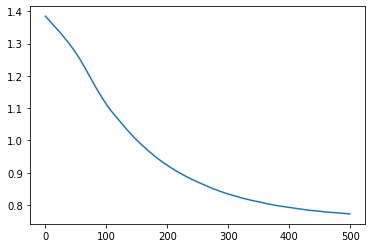

In [69]:
plt.plot(L_classif)
plt.show()

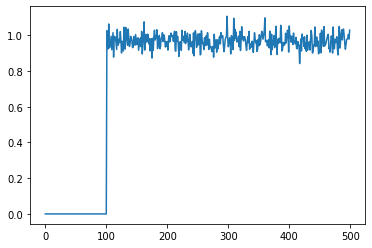

In [70]:
plt.plot(L_sw)
plt.show()

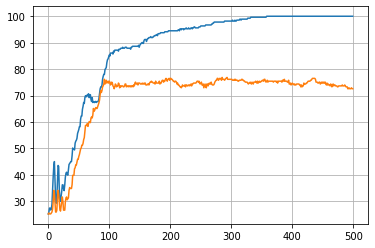

In [73]:
plt.plot(L_acc)
plt.plot(L_acc_test)
plt.grid(True)
plt.show()

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


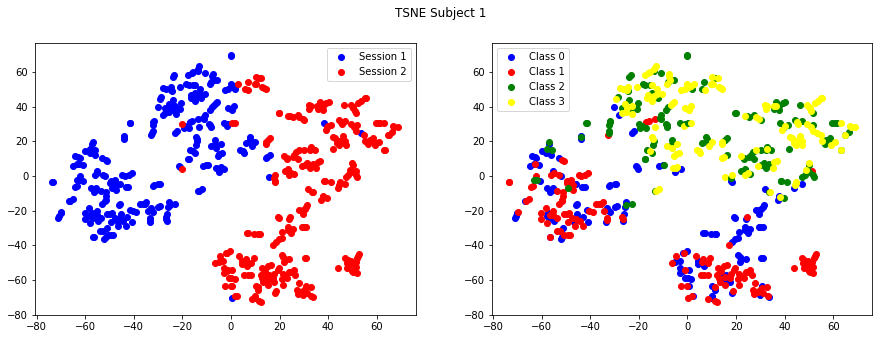

In [72]:
plot_tsne(model(cov_Xs[:,:,freq]).type(torch.float32), model(cov_Xt[:,:,freq]).type(torch.float32), 
          suptitle="TSNE Subject 1")

### Gradient descent on particles

In [12]:
log_Xs = linalg.sym_logm(cov_Xs[:,0,0].detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0].detach().cpu()).reshape(-1, d*d)

for k in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(log_Xs, ys)
    print(k, neigh.score(log_Xt, yt))

1 0.5587188612099644
2 0.6263345195729537
3 0.6654804270462633
4 0.6690391459074733
5 0.6868327402135231
6 0.6619217081850534
7 0.6903914590747331
8 0.6868327402135231
9 0.6761565836298933


In [13]:
n_epochs = 5000

pbar = trange(n_epochs)

# manifold = geoopt.SymmetricPositiveDefinite()
manifold = geoopt.SymmetricPositiveDefinite("LEM")

x = deepcopy(cov_Xs[:,0,0]).requires_grad_(True)

optimizer_sw = RiemannianSGD([x], lr=10)
# optimizer_sw = RiemannianAdam([x], lr=1e-2)
optimizer_sw._default_manifold = manifold

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_sw)

L_sw = []

for e in pbar:
    optimizer_sw.zero_grad()
    
    sw = sliced_wasserstein_spd(x, cov_Xt[:,0,0], 500, device=device)
    sw.backward()
    optimizer_sw.step()
    
    L_sw.append(sw.item())
    pbar.set_postfix_str(f"loss = {sw.item():.3f}")
    
#     if epochs == 100:
#         optimizer.lr = 1e-3


  0%|                                                                                                                                                                                     | 0/5000 [00:00<?, ?it/s]/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [44:57<00:00,  1.85it/s, loss = 0.001]


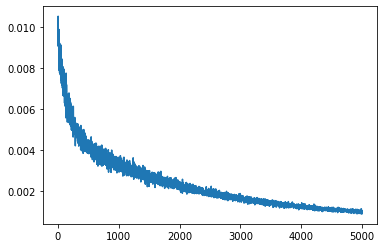

In [14]:
plt.plot(L_sw)
plt.show()

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


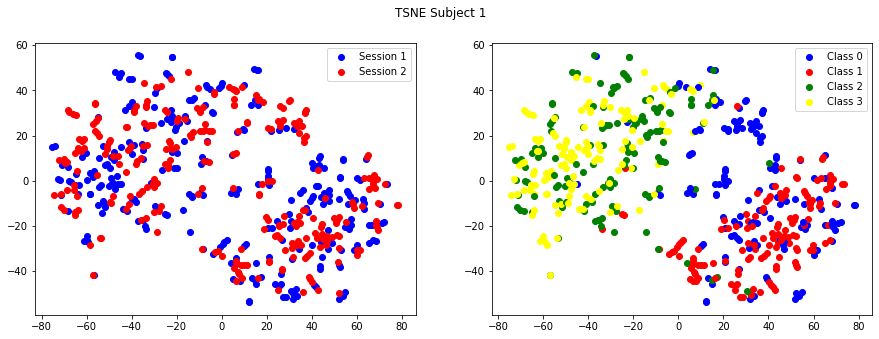

In [15]:
plot_tsne(x, cov_Xt, suptitle="TSNE Subject 1")

In [16]:
log_Xs = linalg.sym_logm(x.detach().cpu()).reshape(-1, d*d)

for k in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(log_Xs, ys)
    print(k, neigh.score(log_Xt, yt))

1 0.6120996441281139
2 0.6476868327402135
3 0.6832740213523132
4 0.697508896797153
5 0.693950177935943
6 0.6832740213523132
7 0.6868327402135231
8 0.7046263345195729
9 0.7153024911032029
